# 目的

学習した機械学習器の学習・予測データの予測に寄与した特徴量を可視化する

In [1]:
# 基本的なライブラリ
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)

# XAI
import shap

# config python file
import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


# SHAP

In [2]:
def save_shap_instances(
    shap_explainer: callable,
    shap_values: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    shap_instances_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(shap_instances_path)
    functions.dill_dump(
        shap_explainer, "{0}/shap_explainer.pkl".format(shap_instances_path)
    )
    functions.dill_dump(shap_values, "{0}/shap_values.pkl".format(shap_instances_path))

In [3]:
def explain_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)

        pipeline_path = "{0}/{1}".format(input_pipe_path, val_step)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.Explainer(
        _estimator.predict, _X_test, feature_names=_X_test.columns, max_evals=829
    )
    shap_values = explainer(_X_test)
    shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            val_step=val_step,
            save_file_path=output_file_path,
        )

In [10]:
# 層別化する特徴量
def loop_exec():
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            print("subgroup: ", subgroup)
            for model_order_dict in model_order_dicts:
                print(".........." * 10)
                print("model_order_dict name: ", model_order_dict["model_name"])
                input_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                input_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                output_file_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_EXPLAIN_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                explain_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    input_pipe_path=input_pipe_path,
                    output_file_path=output_file_path,
                )

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
80
subgroup:  claudin-low
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


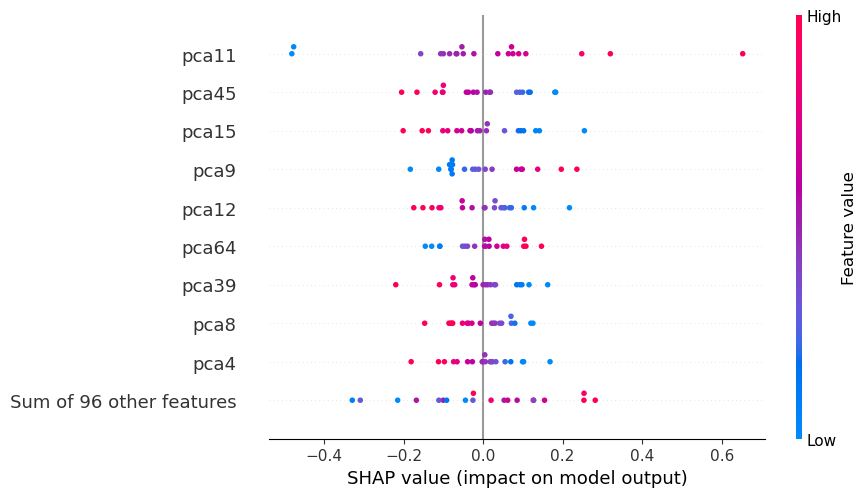

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


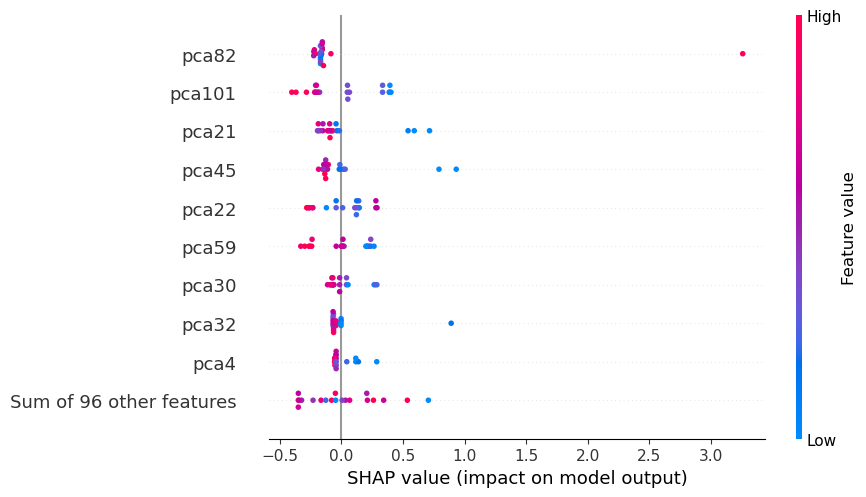

....................................................................................................
model_order_dict name:  RandomSurvivalForest


Permutation explainer: 21it [00:33,  2.25s/it]                                                                                                      


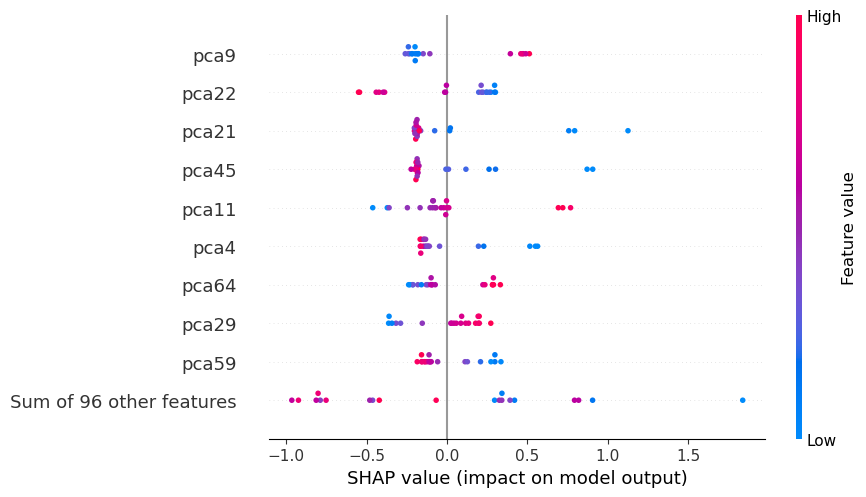

....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


Permutation explainer: 21it [00:32,  2.30s/it]                                                                                                      


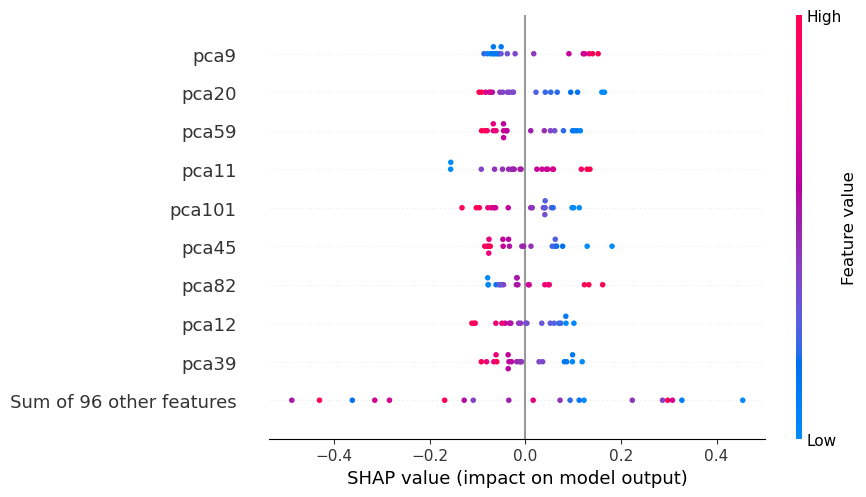

subgroup:  LumA
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


Permutation explainer: 69it [01:05,  1.15s/it]                                                                                                      


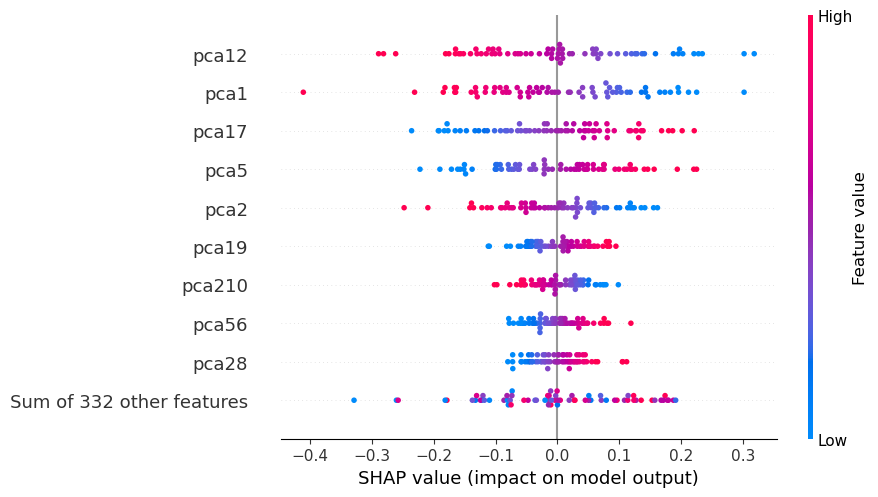

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


Permutation explainer: 69it [01:32,  1.51s/it]                                                                                                      


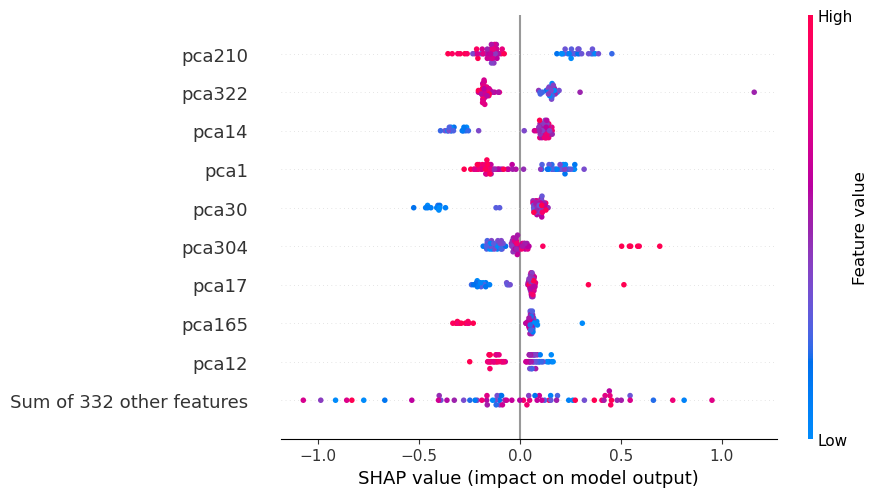

....................................................................................................
model_order_dict name:  RandomSurvivalForest


Permutation explainer: 69it [25:51, 22.82s/it]                                                                                                      


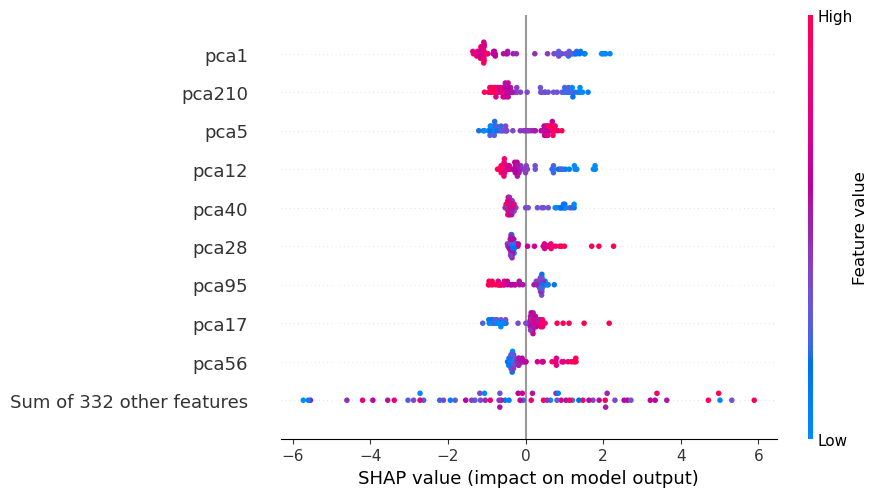

....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


Permutation explainer: 69it [25:45, 22.73s/it]                                                                                                      


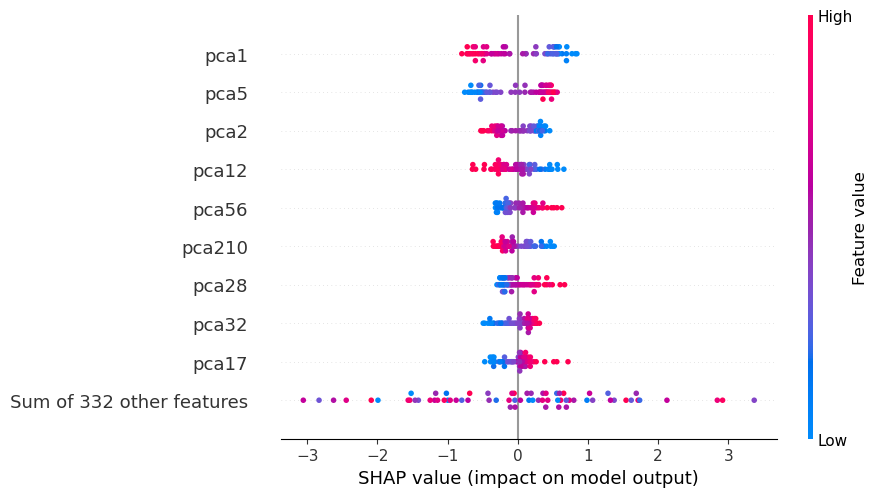

subgroup:  LumB
....................................................................................................
model_order_dict name:  ComponentwiseGradientBoostingSurvivalAnalysis


Permutation explainer: 47it [00:16,  1.01s/it]                                                                                                      


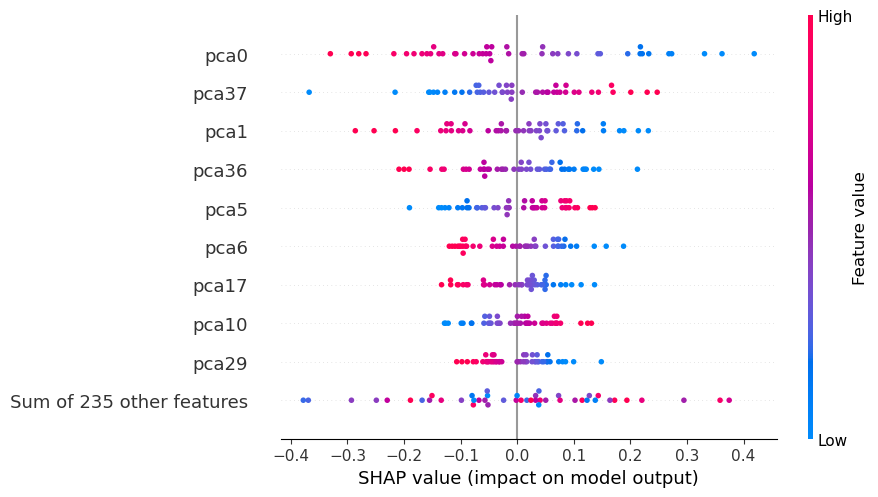

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis


Permutation explainer: 47it [00:28,  1.09it/s]                                                                                                      


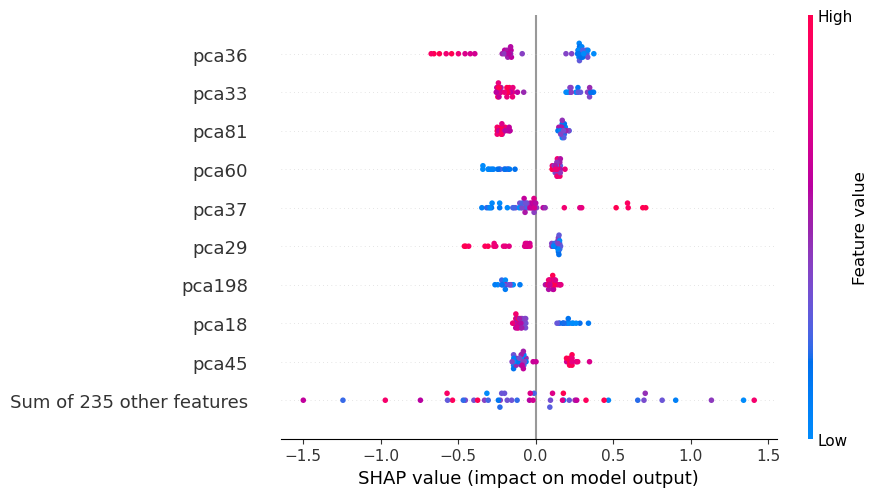

....................................................................................................
model_order_dict name:  RandomSurvivalForest


Permutation explainer: 47it [07:54, 10.55s/it]                                                                                                      


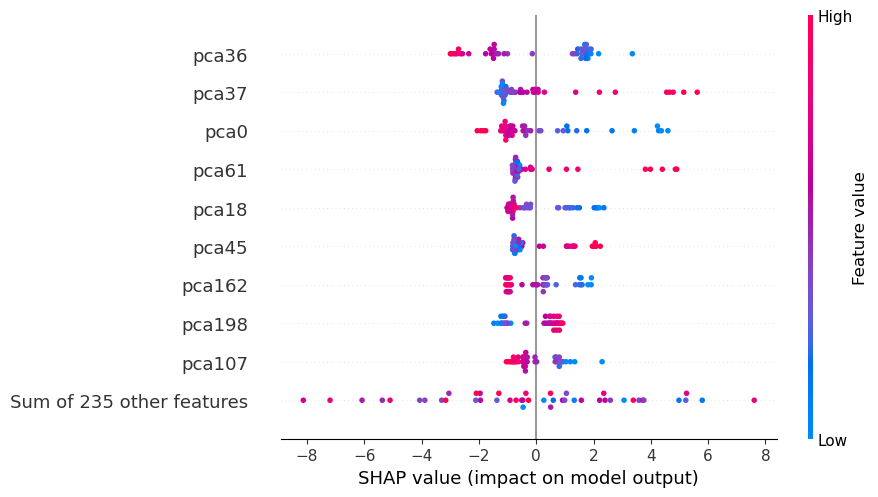

....................................................................................................
model_order_dict name:  ExtraSurvivalTrees


Permutation explainer:  80%|██████████████████████████████████████████████████████████████████████▊                 | 37/46 [06:10<01:34, 10.46s/it]

In [ ]:
for p in range(80, 82):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                    ComponentwiseGradientBoostingSurvivalAnalysis(
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": RandomSurvivalForest().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    RandomSurvivalForest().__class__.__name__,
                    RandomSurvivalForest(
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": ExtraSurvivalTrees().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ExtraSurvivalTrees().__class__.__name__,
                    ExtraSurvivalTrees(
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
    ]
    loop_exec()

# analysis model for each subtypes

## claudin-low

preprocess: pca 80% (maybe not best)  
best model: ComponentwiseGradientBoostingSurvivalAnalysis  

## LumA

preprocess: pca 80% (maybe not best)  
best model: GradientBoostingSurvivalAnalysis	  

## LumB

preprocess: pca 80% (maybe not best)  
best model: GradientBoostingSurvivalAnalysis	  

## Her2

preprocess: pca 80% (maybe not best)  
best model: GradientBoostingSurvivalAnalysis	  

## Normal

preprocess: pca 80% (maybe not best)  
best model: RandomSurvivalForest	  

## Basal

preprocess: pca 80% (maybe not best)  
best model: GradientBoostingSurvivalAnalysis	  